# Projet de conception et de programmation.

Ceci est le notebook regroupant les différentes implémentations dans le cadre du projet de conception et de programmation intitulé : Investigating feature selection techniques to improve data mining tasks.

Il est constitué de cinq parties : 
1. Une introduction au data mining.
1. Le premier chapitre sur l'explication d'une thoerie issue du data mining.
1. Le deuxième chapitre sur les algorithmes de cette thoerie
1. Le troisème chapitre d'application des algorithmes sur des dataset.
1. Une conclusion.
Et une bibliographie.

# Importations.

In [100]:
from __future__ import unicode_literals # lettre grec

import pandas as pd # DataFrame, ...
import numpy as np # array, ...
from fractions import Fraction
from itertools import combinations # combinaison
from functools import reduce

# visualistion
import seaborn as sns
from matplotlib import pyplot as plt

# sklearn
## preprocessing
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

##
from sklearn.neighbors import KNeighborsClassifier

## metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# fuzzy sklearn
from frlearn.base import probabilities_from_scores, select_class
from frlearn.classifiers import FRNN
from frlearn.feature_preprocessors import FRFS, RangeNormaliser

# Fonctions.

## Fonction différence entre deux listes.

In [2]:
def diff_list(list1, list2):
	"""
	Renvoie la différence entre deux listes.

	@param list1 une première liste.
	@param list2 une deuxième liste.

	@return les éléments présents dans list1 mais pas dans list2.
	"""
	# liste1 = list1.copy() if len(list1) > len(list2) else list2.copy()
	# liste2 = list1.copy() if liste1 == list2 else list2.copy()

	set_list2 = set(list2)
	diff = [x for x in list1 if x not in set_list2]
	return diff

### Test.

In [3]:
list1 = [1, 2, 3, 4, 5]
list2 = [1, 2, 4]
diff_list(list1, list2)

[3, 5]

Les éléments 3 et 5 sont présent dans la list1 mais pas dans la list2.

In [4]:
list1 = [1, 2, 4]
list2 = [1, 2, 3, 4, 5]
diff_list(list1, list2)

[]

Tous les éléments dans la list1 sont présent dans la list2. La fonction renvoie une liste vide.

## Fonction combinaison des attributs dans un système de décision.

In [5]:
def combinaisons(DS, d):
	"""
	Renvoie la liste des combinaisons des attributs du dataframe en 
	paramètre.

	@param DS Le système de décision.
	@param d La colonne de décision.

	@return list_combinaisons La liste des combinaisons des attributs.
	"""
	list_combinaisons = list()
	C = list(DS.columns)
	C.remove(d)
	for n in range(len(C) + 1):
		list_combinaisons += list(combinations(C, n))
	list_combinaisons.remove(())
	return list_combinaisons

### Test.

In [6]:
# création d'un dataframe
data = {
	"Patients" : ["o1", "o2", "o3", "o4", "o5", "o6"],
	"Headache" : ["Yes", "Yes", "Yes", "No", "No", "No"],
	"Muscle-pain" : ["Yes", "No", "No", "Yes", "Yes", "Yes"],
	"Temperature" : ["very high", "high", "high", "normal", "high", "very high"],
	"Flu" : ["Yes", "Yes", "No", "No", "Yes", "Yes"]
}
df = pd.DataFrame(data)

# initialisation de l'index
df.set_index("Patients", inplace=True)

# affichage des attributs
df.columns[:-1]

Index(['Headache', 'Muscle-pain', 'Temperature'], dtype='object')

La liste des combinaisons avec les attributs ci-dessus.

In [7]:
combinaisons(df, "Flu")

[('Headache',),
 ('Muscle-pain',),
 ('Temperature',),
 ('Headache', 'Muscle-pain'),
 ('Headache', 'Temperature'),
 ('Muscle-pain', 'Temperature'),
 ('Headache', 'Muscle-pain', 'Temperature')]

## Dessiner *roc curve*.

In [76]:
def plot_roc_curve(y_true, proba, roc):
	# calculate ROC Curve
	# For the Random Model
	random_probs = [0 for _ in range(len(y_true))]
	random_fpr, random_tpr, _ = roc_curve(y_true, random_probs)
	
	# For the actual model
	model_fpr, model_tpr, _ = roc_curve(y_true, proba)
	
	# Plot the roc curve for the model and the random model line
	plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')
	plt.plot(model_fpr, model_tpr, marker='.', label='Model')
	
	# Create labels for the axis
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	
	# show the legend
	plt.legend()
	
	# show the plot
	plt.show()

# Chapitre 3: Implémentation et tests.

## Jeu de test.

In [8]:
data = {
	"Patients" : ["o1", "o2", "o3", "o4", "o5", "o6"],
	"Headache" : ["Yes", "Yes", "Yes", "No", "No", "No"],
	"Muscle-pain" : ["Yes", "No", "No", "Yes", "Yes", "Yes"],
	"Temperature" : ["very high", "high", "high", "normal", "high", "very high"],
	"Flu" : ["Yes", "Yes", "No", "No", "Yes", "Yes"]
}

df = pd.DataFrame(data)
df.set_index("Patients", inplace=True)
df

,Headache,Muscle-pain,Temperature,Flu
Patients,,,,
o1,Yes,Yes,very high,Yes
o2,Yes,No,high,Yes
o3,Yes,No,high,No
o4,No,Yes,normal,No
o5,No,Yes,high,Yes
o6,No,Yes,very high,Yes


In [9]:
data2 = {
	"x" : ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"],
	"a" : [1, 0, 2, 1, 1, 2, 2, 0],
	"b" : [0, 1, 2, 1, 0, 2, 1, 1],
	"c" : [2, 1, 0, 0, 2, 0, 1, 1],
	"d" : [2, 1, 1, 2, 0, 1, 1, 1],
	"e" : [0, 2, 1, 2, 1, 1, 2, 1],
}

df2 = pd.DataFrame(data2)
df2.set_index("x", inplace=True)
df2

,a,b,c,d,e
x,,,,,
x1,1,0,2,2,0
x2,0,1,1,1,2
x3,2,2,0,1,1
x4,1,1,0,2,2
x5,1,0,2,0,1
x6,2,2,0,1,1
x7,2,1,1,1,2
x8,0,1,1,1,1


## *Indiscernibility Relation*.

### Implémentation.

In [10]:
def IND(DS, d, C):
	"""
	Calcule la Indiscernibility Relation pour un attribut.
	
	@param DS le système de décision.
	@param d la décision.
	@param C La liste des attributs.
	
	@return ind la Indiscernibility Relation.
	"""
	ind = []
	IS = DS.drop(d, axis=1)
	group = IS.groupby(C)

	for g in group:
		gDS = pd.DataFrame(g[1])
		ind.append(list(gDS.index))
	ind.sort()
	return ind

### Test.

On regroupe les objets possèdants les même valeurs pour l'attribut "Headache".

In [11]:
ind = IND(df, "Flu", ["Headache"])
ind

[['o1', 'o2', 'o3'], ['o4', 'o5', 'o6']]

On regroupe les objets possèdants les même valeurs pour l'ensemble d'attribut {"Headache", "Muscle-pain"}.

In [12]:
ind2 = IND(df, "Flu", ["Headache", "Muscle-pain"])
ind2

[['o1'], ['o2', 'o3'], ['o4', 'o5', 'o6']]

### Implémentation 2.

In [13]:
def IND_C(DS, d):
	"""
	Calcule la Indiscernibility Relation pour tous les
	attributs du système de décision.
	
	@param DS le système de décision.
	@param d la décision.
	
	@return ind_c la Indiscernibility Relation.
	"""
	ind = []
	IS = DS.drop(d, axis=1)
	group = IS.groupby(list(IS.columns))

	for g in group:
		gDS = pd.DataFrame(g[1])
		ind.append(list(gDS.index))
	ind.sort()
	return ind

### Test.

On regroupe les objets ayant les même valeurs pour tous les attributs.

In [14]:
ind_c = IND_C(df, "Flu")
ind_c

[['o1'], ['o2', 'o3'], ['o4'], ['o5'], ['o6']]

In [15]:
ind_c2 = IND_C(df2, "e")
ind_c2

[['x1'], ['x2', 'x8'], ['x3', 'x6'], ['x4'], ['x5'], ['x7']]

### Fonction groupe_ind_c_obj

### Implémentation.

In [16]:
def groupe_ind_c_obj(ind_c, obj):
	"""
	Renvoie le groupe indiscernable de l'objet obj sans ce dernier.

	@param ind_c la liste des objets indiscernable.
	@param obj l'index d'un objet.

	@return le groupe indiscernable de l'objet.
	"""
	for g in ind_c:
		for obj2 in g:
			if obj == obj2:
				copy_g = g.copy()
				copy_g.remove(obj)
				return copy_g
	return []

### Test.

On affiche les objets qui sont dans le même groupe indiscernable. Si le retour est vide c'est que l'objet ne possède est seul dasn son groupe, i.e il ne n'existe pas d'objet indiscernable à cette objet.

On cherche le groupe indiscernable de o3 qui est [o2, o3], la fonction nous renvoie uniquement [o3].

In [17]:
groupe_ind_c_obj(ind_c, "o3")

['o2']

On cherche le groupe indiscernable de o1 qui est [o1], la fonction nous renvoie une liste vide.

In [18]:
groupe_ind_c_obj(ind_c, "o1")

[]

On cherche le groupe indiscernable de x8 qui est [x2, x8], la fonction nous renvoie uniquement [x8].

In [19]:
groupe_ind_c_obj(ind_c2, "x8")

['x2']

## *B-lower approximation*.

### Implémentation.

In [20]:
def b_lower(DS, ind_c, d, d_value):
	"""
	Renvoie la B-lower approximation.

	@param DS le système de décision.
	@param ind_c la liste des objets indiscernables.
	@param d le nom de la colone de décision.
	@param d_value la value de décision.

	@return la B-lower approximation.
	"""
	X = DS.groupby(d)
	Xi = None
	for name, groupe in X:
		if name == d_value:
			Xi = pd.DataFrame(groupe)

	if Xi is not None:
		CXi = []

		for index in Xi.index:
			# Nous regardons le groupe indiscernable de cet objet.
			idc_obj = groupe_ind_c_obj(ind_c, index)
			
			# Si il possèdent des objets indiscernables.
			possede_indiscernable = False
			if len(idc_obj) != 0:
				for index_obj2 in idc_obj:
					# On récupère la décision des objets.
					obj_d = DS[DS.index == index_obj2][d].iloc[0]
					obj2_d = DS[DS.index == index][d].iloc[0]
					
					if obj_d != obj2_d:
						possede_indiscernable = True
						break
			if not possede_indiscernable:
				CXi.append(index)
		CXi.sort()
		return CXi
	else:
		return "error"

In [21]:
def b_lower_opti(DS, ind_c, d, d_value):
	"""
	Renvoie la B-lower approximation.

	@param DS le système de décision.
	@param ind_c la liste des objets indiscernables.
	@param d le nom de la colone de décision.
	@param d_value la value de décision.

	@return la B-lower approximation.
	"""
	X = DS.groupby(d)
	Xi = None
	for name, groupe in X:
		if name == d_value:
			Xi = pd.DataFrame(groupe)

	if Xi is not None:
		CXi = []

		for index in Xi.index:
			# Nous regardons le groupe indiscernable de cet objet.
			idc_obj = groupe_ind_c_obj(ind_c, index)
			
			# Si il possèdent des objets indiscernables.
			possede_indiscernable = False
			if len(idc_obj) != 0:
				for index_obj2 in idc_obj:
					# On récupère la décision des objets.
					obj_d = DS[DS.index == index_obj2][d].iloc[0]
					obj2_d = DS[DS.index == index][d].iloc[0]
					
					if obj_d != obj2_d:
						possede_indiscernable = True
						break
			if not possede_indiscernable:
				CXi.append(index)
		CXi.sort()
		return CXi
	else:
		return "error"

### Test.

On rend tous les objets tel que la décision "Flu" soit égal à "Yes" et pour chaque objet on le supprime si il un existe un objet identique mais qui ne possède pas le même valeur de décision (ici "No").

In [22]:
blower_yes = b_lower(df, ind_c, "Flu", "Yes")
blower_yes

['o1', 'o5', 'o6']

On rend tous les objets tel que la décision "Flu" soit égal à "No" et pour chaque objet on le supprime si il un existe un objet identique mais qui ne possède pas le même valeur de décision (ici "Yes").

In [23]:
blower_no = b_lower(df, ind_c, "Flu", "No")
blower_no

['o4']

## *B-upper approximation*.

### Implémentation.

In [24]:
def b_upper(DS, ind_c, d, d_value):
	"""
	Renvoie la B-upper approximation.

	@param DS le système de décision.
	@param ind_c la liste des objets indiscernables.
	@param d le nom de la colone de décision.
	@param d_value la value de décision.

	@return la B-upper approximation.
	"""
	X = DS.groupby(d)
	Xi = None
	for name, groupe in X:
		if name == d_value:
			Xi = pd.DataFrame(groupe)

	if Xi is not None:
		CXi = list(Xi.index)
		for index in Xi.index:
			# Nous regardons le groupe indiscernable de cet objet.
			idc_obj = groupe_ind_c_obj(ind_c, index)
			
			# Si il possèdent des objets indiscernables.
			list_add = []
			if len(idc_obj) != 0:
				for index_obj2 in idc_obj:
					
					# On récupère la décision des objets.
					obj_d = DS[DS.index == index_obj2][d].iloc[0]
					obj2_d = DS[DS.index == index][d].iloc[0]
					
					if obj_d != obj2_d:
						list_add.append(index_obj2)
			CXi += list_add
		CXi.sort()
		return CXi
	else:
		return "error"

### Test.

On rend tous les objets tel que la décision "Flu" soit égal à "Yes" et pour chaque objet on ajout les objets indiscernables à ce dernier.

In [25]:
bupper_yes = b_upper(df, ind_c, "Flu", "Yes")
bupper_yes

['o1', 'o2', 'o3', 'o5', 'o6']

On rend tous les objets tel que la décision "Flu" soit égal à "No" et pour chaque objet on ajout les objets indiscernables à ce dernier.

In [26]:
bupper_no = b_upper(df, ind_c, "Flu", "No")
bupper_no

['o2', 'o3', 'o4']

## *B-boundary region*.

### Implémentation.

In [27]:
def b_boundary(DS, bupper, blower):
	"""
	Calcule la B-boundary region.

	@param DS le système de décision.
	@param bupper la B-upper approximation.
	@param blower la B-lower approximation.

	@return la différence entre les deux approximations.
	"""
	return diff_list(bupper, blower)

### Test.

bupper_yes = ['o1', 'o2', 'o3', 'o5', 'o6']

blower_yes = ['o1', 'o5', 'o6']

Les éléments qui sont présents dans bupper_yes mais pas dans blower_yes sont o2 et o3.

In [28]:
b_boundary(df, bupper_yes, blower_yes)

['o2', 'o3']

bupper_no = ['o2', 'o3', 'o4']

blower_no = ['o4']

Les éléments qui sont présents dans bupper_no mais pas dans blower_no sont o2 et o3.

In [29]:
b_boundary(df, bupper_no, blower_no)

['o2', 'o3']

## *Positive Region*.

### Implémentation.

In [30]:
def POS(DS, d, C):
	"""
	Calcul la Positive Region avec les C attributs.

	@param DS Le système de décision.
	@param d La colonne de décision.
	@param C La liste des attributs.

	@return La Positive region des C attributs.
	"""
	attr = C.copy()
	attr.append(d)
	ds = DS[attr]
	ind = IND(ds, d, C)
	d_values = list(ds[d])
	d_values = [*set(d_values)]
	POS = []
	for d_value in d_values:
		POS += b_lower(ds, ind, d, d_value)
	POS.sort()
	return POS

### Test.

Nous calculons la POS pour toutes les combinaisons d'attributs.

In [31]:
for combi in combinaisons(df, "Flu"):
	liste_combi = list(combi)
	print("POS{{{}}} = {}".format(liste_combi, POS(df, "Flu", liste_combi)))

POS{['Headache']} = []
POS{['Muscle-pain']} = []
POS{['Temperature']} = ['o1', 'o4', 'o6']
POS{['Headache', 'Muscle-pain']} = ['o1']
POS{['Headache', 'Temperature']} = ['o1', 'o4', 'o5', 'o6']
POS{['Muscle-pain', 'Temperature']} = ['o1', 'o4', 'o5', 'o6']
POS{['Headache', 'Muscle-pain', 'Temperature']} = ['o1', 'o4', 'o5', 'o6']


### Implémentation 2.

In [32]:
def POS_C(DS, d):
	"""
	Calcule la Positive Region avec tous les attributs.

	@param DS Le système de décision.
	@param d La colonne de décision.

	@return La Positive region de tous les attributs.
	"""
	d_values = list(DS[d])
	d_values = [*set(d_values)]
	POS_C = []
	ind_c = IND_C(DS, d)
	for d_value in d_values:
		blower = b_lower(DS, ind_c, d, d_value)
		POS_C += blower
	POS_C.sort()
	return POS_C

### Test.

Nous calculons la POS pour tous les attributs.

In [33]:
POS_C(df, "Flu")

['o1', 'o4', 'o5', 'o6']

In [34]:
POS_C(df2, "e")

['x1', 'x3', 'x4', 'x5', 'x6', 'x7']

## *Negative Region*.

### Implémentation.

In [35]:
def NEG_C(DS, d):
	"""
	Calcule la Negative Region avec tous les attributs.

	@param DS Le système de décision.
	@param d La colonne de décision.

	@return La Negative region de tous les attributs.
	"""
	d_values = list(DS[d])
	d_values = [*set(d_values)]
	NEG_C = []
	ind_c = IND_C(DS, d)
	for d_value in d_values:
		NEG_C += b_upper(DS, ind_c, d, d_value)
	NEG_C = [*set(NEG_C)]
	neg = diff_list(list(DS.index), NEG_C)
	neg.sort()
	return neg

### Test.

In [36]:
NEG_C(df, "Flu")

[]

In [37]:
NEG_C(df2, "e")

[]

## *Reduct*.

### Implémentation.

In [38]:
def reduct(DS, d):
	"""
	Renvoie toutes les réductions d'attributs possibles.

	@param DS Le système de décision.
	@param d La colonne de décision.

	@return reducts : La liste des réductions.
	"""
	reducts = []
	pos_c = POS_C(DS, d)
	print("pos_c", pos_c)
	C = list(DS.columns)
	C.remove(d)
	for combi in combinaisons(DS, d):
		liste_combi = list(combi)
		if liste_combi != C:
			pos = POS(DS, d, liste_combi)
			print("POS({}) = {}".format(liste_combi, pos))
			if pos == pos_c:
				print("reduct possible", liste_combi)
				reducts.append(liste_combi)
	reducts.sort()

	if len(reducts)!= 0:
		# On garde les plus petites reductions
		# print("Selection des réductions minimales...")
		min_len = min([len(x) for x in reducts])
		reducts = [x for x in reducts if len(x) == min_len]

	return reducts

### Test.

In [39]:
reducts = reduct(df, "Flu")
reducts

pos_c ['o1', 'o4', 'o5', 'o6']
POS(['Headache']) = []
POS(['Muscle-pain']) = []
POS(['Temperature']) = ['o1', 'o4', 'o6']
POS(['Headache', 'Muscle-pain']) = ['o1']
POS(['Headache', 'Temperature']) = ['o1', 'o4', 'o5', 'o6']
reduct possible ['Headache', 'Temperature']
POS(['Muscle-pain', 'Temperature']) = ['o1', 'o4', 'o5', 'o6']
reduct possible ['Muscle-pain', 'Temperature']


[['Headache', 'Temperature'], ['Muscle-pain', 'Temperature']]

In [40]:
# création d'un dataframe
data3 = {
	"x" : ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"],
	"a" : [1, 0, 2, 1, 1, 2, 2, 0],
	"b" : [0, 1, 0, 1, 0, 2, 1, 1],
	"c" : [2, 1, 0, 0, 2, 0, 1, 1],
	"d" : [2, 1, 1, 2, 0, 1, 1, 0],
	"e" : [0, 2, 1, 2, 1, 1, 2, 1],
}

df3 = pd.DataFrame(data3)
df3.set_index("x", inplace=True)
df3

,a,b,c,d,e
x,,,,,
x1,1,0,2,2,0
x2,0,1,1,1,2
x3,2,0,0,1,1
x4,1,1,0,2,2
x5,1,0,2,0,1
x6,2,2,0,1,1
x7,2,1,1,1,2
x8,0,1,1,0,1


In [41]:
reduct(df3, "e")

pos_c ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
POS(['a']) = []
POS(['b']) = ['x6']
POS(['c']) = []
POS(['d']) = ['x5', 'x8']
POS(['a', 'b']) = ['x3', 'x4', 'x6', 'x7']
POS(['a', 'c']) = ['x3', 'x4', 'x6', 'x7']
POS(['a', 'd']) = ['x2', 'x5', 'x8']
POS(['b', 'c']) = ['x3', 'x4', 'x6']
POS(['b', 'd']) = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
reduct possible ['b', 'd']
POS(['c', 'd']) = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
reduct possible ['c', 'd']
POS(['a', 'b', 'c']) = ['x3', 'x4', 'x6', 'x7']
POS(['a', 'b', 'd']) = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
reduct possible ['a', 'b', 'd']
POS(['a', 'c', 'd']) = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
reduct possible ['a', 'c', 'd']
POS(['b', 'c', 'd']) = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
reduct possible ['b', 'c', 'd']


[['b', 'd'], ['c', 'd']]

## *Core*.

### Implémentation.

In [42]:
def core(reducts):
	"""
	Calcul l'intersection de toutes les réductions.

	@param reducts la liste des réductions.

	@return le core du système de décision.
	"""
	return list(reduce(lambda i, j: i & j, (set(x) for x in reducts)))

### Test.

In [43]:
core(reducts)

['Temperature']

## Dépendance des attributs.

### Implémentation.

In [44]:
def dependance_attributs(DS, C, d):
	"""
	Calcul la dépendance des attributs.

	@param DS Le système de décision.
	@param C la liste des attributs.
	@param d la colonne de décision.

	@return la dépendance des attributs.
	"""
	ds = DS[C]
	if len(list(ds.columns)) == 1 and list(ds.columns)[0] == d:
		return 0
	ind_c = IND_C(ds, d)
	pos_c = POS_C(ds, d)
	# dep = Fraction(len(pos_c), len(ds.index))
	dep = float(len(pos_c)) / len(ds.index)
	return dep

### Test.

## *QuickReduct*.

### Implémentation.

In [45]:
def quickReduct(DS, d):
	"""
	L'algorithme de quickReduct.

	@param DS Le système de décision.
	@param d la colonne de décision.

	@return une sous liste d'attributs.
	"""
	C = list(DS.columns)
	C.remove(d)
	print("C :", C)
	# calcul de lambda C.
	dep_C = dependance_attributs(DS, DS.columns, d)
	print("λC :", dep_C, "\n")
	R = []
	while True:
		T = R
		# calcul de lambda T.
		attr = T.copy() + [d]
		dep_T = dependance_attributs(DS, attr, d)
		print("λT({}) = {}".format(attr[:-1], dep_T))
		
		# calcul de C - R.
		C_R = diff_list(C, R)
		print("C_R", C_R)
		
		# parcours des attributs.
		for x in C_R:
			print("x :", x)
			# calcul de lambda RU{x}.
			attr2 = R.copy() + [x, d]
			dep_RUx = dependance_attributs(DS, attr2, d)
			print("λRUx({}) = {}".format(attr2[:-1], dep_RUx))
			
			# changement meilleur dépendance.
			if dep_RUx > dep_T:
				T = R.copy() + [x]
				print("changement R =", T)
				attr3 = T.copy() + [d]
				dep_T = dependance_attributs(DS, attr3, d)
		
		R = T.copy()
		# calcul de lambda R.
		attr4 = R.copy() + [d]
		dep_R = dependance_attributs(DS, attr4, d)
		print("λR({}) = {}".format(attr4[:-1], dep_R))
		if dep_R == dep_C:
			return R

### Test.

In [46]:
quickReduct(df, "Flu")

C : ['Headache', 'Muscle-pain', 'Temperature']
λC : 0.6666666666666666 

λT([]) = 0
C_R ['Headache', 'Muscle-pain', 'Temperature']
x : Headache
λRUx(['Headache']) = 0.0
x : Muscle-pain
λRUx(['Muscle-pain']) = 0.0
x : Temperature
λRUx(['Temperature']) = 0.5
changement R = ['Temperature']
λR(['Temperature']) = 0.5
λT(['Temperature']) = 0.5
C_R ['Headache', 'Muscle-pain']
x : Headache
λRUx(['Temperature', 'Headache']) = 0.6666666666666666
changement R = ['Temperature', 'Headache']
x : Muscle-pain
λRUx(['Temperature', 'Muscle-pain']) = 0.6666666666666666
λR(['Temperature', 'Headache']) = 0.6666666666666666


['Temperature', 'Headache']

2ème test.

In [47]:
data2 = {
	"x" : ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"],
	"a" : [1, 0, 2, 1, 0, 1, 2, 1],
	"b" : [2, 3, 3, 1, 2, 1, 2, 2],
	"c" : [4, 3, 1, 2, 0, 2, 1, 0],
	"d" : [0, 2, 3, 1, 1, 4, 3, 2],
	"e" : [1, 1, 3, 2, 2, 3, 2, 2],
	"X" : [1, 2, 2, 1, 1, 2, 2, 1],
}

df2 = pd.DataFrame(data2)
df2.set_index("x", inplace=True)
df2

,a,b,c,d,e,X
x,,,,,,
x1,1,2,4,0,1,1
x2,0,3,3,2,1,2
x3,2,3,1,3,3,2
x4,1,1,2,1,2,1
x5,0,2,0,1,2,1
x6,1,1,2,4,3,2
x7,2,2,1,3,2,2
x8,1,2,0,2,2,1


In [48]:
quickReduct(df2, "X")

C : ['a', 'b', 'c', 'd', 'e']
λC : 1.0 

λT([]) = 0
C_R ['a', 'b', 'c', 'd', 'e']
x : a
λRUx(['a']) = 0.25
changement R = ['a']
x : b
λRUx(['b']) = 0.25
x : c
λRUx(['c']) = 0.75
changement R = ['c']
x : d
λRUx(['d']) = 0.75
x : e
λRUx(['e']) = 0.25
λR(['c']) = 0.75
λT(['c']) = 0.75
C_R ['a', 'b', 'd', 'e']
x : a
λRUx(['c', 'a']) = 0.75
x : b
λRUx(['c', 'b']) = 0.75
x : d
λRUx(['c', 'd']) = 1.0
changement R = ['c', 'd']
x : e
λRUx(['c', 'e']) = 1.0
λR(['c', 'd']) = 1.0


['c', 'd']

# Chapitre 4:  Applications

## Chargement du dataset.

Lien : https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

In [49]:
features = ["buying", "maint", "doors", "persons", "lug_boot", "safety"]
label = ["class"]
columns = features + label
columns

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [50]:
df_car = pd.read_csv("data/car.data", names=columns)
df_car

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


### Informations sur le dataset.

In [51]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


## *Data visualization*.

### Répartition des données en fonction des attributs.

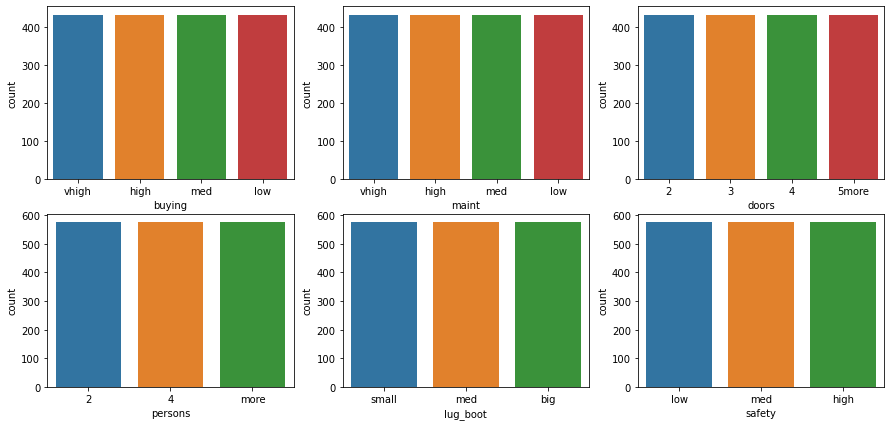

In [52]:
fig, ax = plt.subplots(2,3, figsize=(15, 7))
sns.countplot(x = "buying", data = df_car, ax=ax[0,0])
sns.countplot(x = "maint", data = df_car, ax=ax[0,1])
sns.countplot(x = "doors", data = df_car, ax=ax[0,2])
sns.countplot(x = "persons", data = df_car, ax=ax[1,0])
sns.countplot(x = "lug_boot", data = df_car, ax=ax[1,1])
sns.countplot(x = "safety", data = df_car, ax=ax[1,2])
plt.show()

Les données sont réparties de manière équitables entre les différents attributs.

### Répartition des données en fonction des classes.

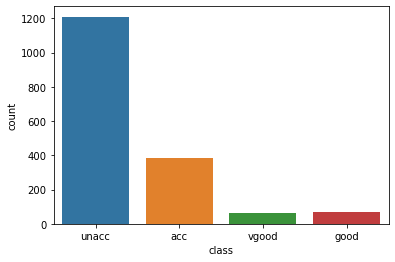

In [53]:
sns.countplot(x = "class", data = df_car)
plt.show()

Il y a une grande majorité de données ayant pour classe "unacc" à l'inverse des autres classes. Nous devons équilibrer cette répartition pour favoriser l'apprentissage de nos modèles.

### Matrice de corrélation.

#### Encodage.

Découpage des attributs et de la classe.

In [54]:
X = df_car.drop("class", axis=1)
y = df_car["class"]
X, y

(     buying  maint  doors persons lug_boot safety
 0     vhigh  vhigh      2       2    small    low
 1     vhigh  vhigh      2       2    small    med
 2     vhigh  vhigh      2       2    small   high
 3     vhigh  vhigh      2       2      med    low
 4     vhigh  vhigh      2       2      med    med
 ...     ...    ...    ...     ...      ...    ...
 1723    low    low  5more    more      med    med
 1724    low    low  5more    more      med   high
 1725    low    low  5more    more      big    low
 1726    low    low  5more    more      big    med
 1727    low    low  5more    more      big   high
 
 [1728 rows x 6 columns],
 0       unacc
 1       unacc
 2       unacc
 3       unacc
 4       unacc
         ...  
 1723     good
 1724    vgood
 1725    unacc
 1726     good
 1727    vgood
 Name: class, Length: 1728, dtype: object)

Encodage.

In [55]:
encoder = LabelEncoder()
yencode = encoder.fit_transform(y)

encoder = OrdinalEncoder(dtype=np.int64)
Xencode = encoder.fit_transform(X)

Concaténation.

In [56]:
car_encode = [list(np.concatenate([x, [y]], axis=0)) for x, y in zip(Xencode, yencode)]
df_car_encode = pd.DataFrame(car_encode, columns=columns)
df_car_encode

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2
...,...,...,...,...,...,...,...
1723,1,1,3,2,1,2,1
1724,1,1,3,2,1,0,3
1725,1,1,3,2,0,1,2
1726,1,1,3,2,0,2,1


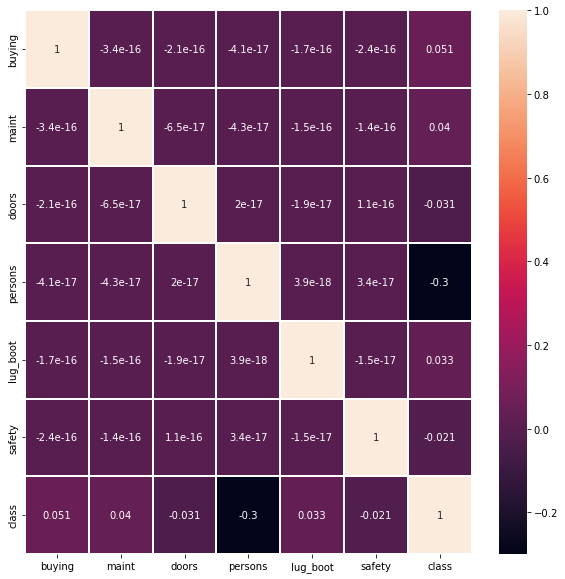

In [57]:
corr_matrix = df_car_encode.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, linewidths=.3)
plt.show()

## *Data reduction*.

### Reduction des données de la classe "unacc".

In [58]:
df_car_unacc = df_car[df_car["class"] == "unacc"].sample(frac=0.33)
df_car_unacc

,buying,maint,doors,persons,lug_boot,safety,class
960,med,vhigh,5more,4,big,low,unacc
1655,low,low,3,2,big,high,unacc
1581,low,med,4,4,big,low,unacc
861,high,low,5more,more,big,low,unacc
134,vhigh,high,2,more,big,high,unacc
...,...,...,...,...,...,...,...
251,vhigh,med,3,2,big,high,unacc
532,high,vhigh,5more,more,small,med,unacc
1533,low,med,2,more,med,low,unacc
756,high,low,2,2,small,low,unacc


### Répartition des données prises aléatoirement.

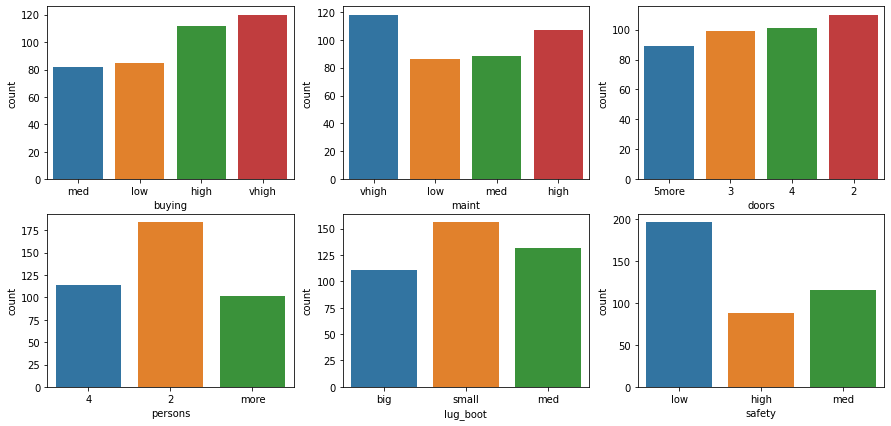

In [59]:
fig, ax = plt.subplots(2,3, figsize=(15, 7))
sns.countplot(x = "buying", data = df_car_unacc, ax=ax[0,0])
sns.countplot(x = "maint", data = df_car_unacc, ax=ax[0,1])
sns.countplot(x = "doors", data = df_car_unacc, ax=ax[0,2])
sns.countplot(x = "persons", data = df_car_unacc, ax=ax[1,0])
sns.countplot(x = "lug_boot", data = df_car_unacc, ax=ax[1,1])
sns.countplot(x = "safety", data = df_car_unacc, ax=ax[1,2])
plt.show()

### Construction du datset réduit.

In [60]:
df_car_sans_unacc = df_car[df_car["class"] != "unacc"]
df_car_sans_unacc

,buying,maint,doors,persons,lug_boot,safety,class
227,vhigh,med,2,4,small,high,acc
230,vhigh,med,2,4,med,high,acc
232,vhigh,med,2,4,big,med,acc
233,vhigh,med,2,4,big,high,acc
239,vhigh,med,2,more,med,high,acc
...,...,...,...,...,...,...,...
1721,low,low,5more,more,small,high,good
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1726,low,low,5more,more,big,med,good


In [61]:
df_car_reduc = pd.concat([df_car_unacc, df_car_sans_unacc], axis=0)
df_car_reduc = df_car_reduc.reset_index(drop=True)
df_car_reduc

,buying,maint,doors,persons,lug_boot,safety,class
0,med,vhigh,5more,4,big,low,unacc
1,low,low,3,2,big,high,unacc
2,low,med,4,4,big,low,unacc
3,high,low,5more,more,big,low,unacc
4,vhigh,high,2,more,big,high,unacc
...,...,...,...,...,...,...,...
912,low,low,5more,more,small,high,good
913,low,low,5more,more,med,med,good
914,low,low,5more,more,med,high,vgood
915,low,low,5more,more,big,med,good


### Suppression des classes vgood et good.
Il y a trop peu des données dans ces classes pour faire de la data augmentations. Nous décidons de les supprimer.

In [62]:
reduc_classes = ["unacc", "acc"]
df_car_reduc = df_car_reduc[df_car_reduc["class"].isin(reduc_classes)]
df_car_reduc = df_car_reduc.reset_index(drop=True)
df_car_reduc

,buying,maint,doors,persons,lug_boot,safety,class
0,med,vhigh,5more,4,big,low,unacc
1,low,low,3,2,big,high,unacc
2,low,med,4,4,big,low,unacc
3,high,low,5more,more,big,low,unacc
4,vhigh,high,2,more,big,high,unacc
...,...,...,...,...,...,...,...
778,low,low,3,more,small,med,acc
779,low,low,4,4,small,med,acc
780,low,low,4,more,small,med,acc
781,low,low,5more,4,small,med,acc


### Nouvelle répartition des classes.

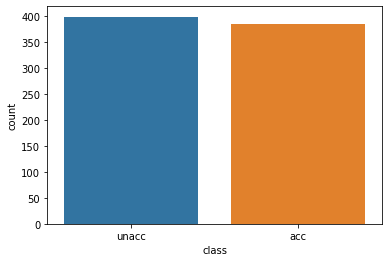

In [63]:
sns.countplot(x = "class", data = df_car_reduc)
plt.show()

## Data cleaning.
### Valeurs manquantes.

In [64]:
df_car_reduc.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

Aucune valeur manquantes.

## Découpage du dataset en trainset et testset.

In [65]:
X = df_car_reduc.drop("class", axis=1)
y = df_car_reduc["class"]
X, y

(    buying  maint  doors persons lug_boot safety
 0      med  vhigh  5more       4      big    low
 1      low    low      3       2      big   high
 2      low    med      4       4      big    low
 3     high    low  5more    more      big    low
 4    vhigh   high      2    more      big   high
 ..     ...    ...    ...     ...      ...    ...
 778    low    low      3    more    small    med
 779    low    low      4       4    small    med
 780    low    low      4    more    small    med
 781    low    low  5more       4    small    med
 782    low    low  5more    more    small    med
 
 [783 rows x 6 columns],
 0      unacc
 1      unacc
 2      unacc
 3      unacc
 4      unacc
        ...  
 778      acc
 779      acc
 780      acc
 781      acc
 782      acc
 Name: class, Length: 783, dtype: object)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, test_size=0.2)
"train", X_train.shape, y_train.shape, "test", X_test.shape, y_test.shape

('train', (626, 6), (626,), 'test', (157, 6), (157,))

## *Data transformation*.

### Encodage des attributs.

In [68]:
encoder_x = OrdinalEncoder(dtype=np.int32)
X_train_encode = encoder_x.fit_transform(X_train)
X_test_encode = encoder_x.fit_transform(X_test)
X_train_encode

array([[1, 3, 2, 2, 2, 0],
       [2, 3, 3, 1, 0, 2],
       [2, 0, 1, 2, 2, 2],
       ...,
       [2, 2, 2, 2, 1, 2],
       [0, 2, 1, 2, 1, 2],
       [0, 2, 2, 2, 0, 2]])

### Encodage de la classe.

In [69]:
encoder_y = LabelEncoder()
y_train_encode = encoder_y.fit_transform(y_train)
y_test_encode = encoder_y.fit_transform(y_test)
y_train_encode, y_test_encode

(array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 

## Classification.

### Via *Reduct*.

In [ ]:
reduc = reduct(df_car_reduc, "class")
if len(reduc) == 0:
	features_selected = diff_list(features, reduc)
else:
	features_selected = reduc
features_selected

### Via *QuickReduct*.

In [ ]:
features_selected2 = quickReduct(df_car_reduc, "class")
features_selected2

#### *Validation curve*.

In [ ]:
model = KNeighborsClassifier()
k = np.arange(1, 50)
train_score, val_score = validation_curve(model, X_train_encode, y_train_encode, param_name="n_neighbors", param_range=k, cv=10, scoring="roc_auc")
plt.plot(k, val_score.mean(axis=1), label = 'validation')
plt.plot(k, train_score.mean(axis=1), label = 'train')
plt.xlabel('score')
plt.ylabel('n_neighbors') # best k = 5
plt.legend()
plt.show()

### Via *VarianceThreshold*.

Variance des attributs.

In [85]:
X_train_encode.var(axis=0)

array([1.29988313, 1.26247078, 1.20198481, 0.59541283, 0.65458461,
       0.75709663])

Selection des attributs.

In [86]:
selector = VarianceThreshold(threshold=1)
selector.fit_transform(X_train_encode)
features_selected3 = list(np.array(features)[selector.get_support()])
features_selected3

['buying', 'maint', 'doors']

In [87]:
X_train_encode_select = np.array([list(x[:3]) for x in X_train_encode])
X_test_encode_select = np.array([list(x[:3]) for x in X_test_encode])
X_train_encode_select.shape, X_test_encode_select.shape

((626, 3), (157, 3))

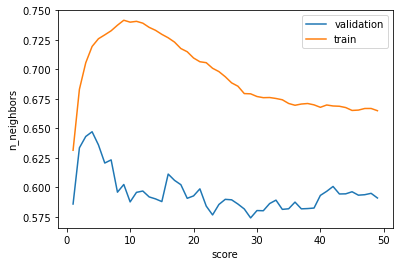

In [88]:
model = KNeighborsClassifier()
k = np.arange(1, 50)
train_score, val_score = validation_curve(model, X_train_encode_select, y_train_encode, param_name="n_neighbors", param_range=k, cv=10, scoring="roc_auc")
plt.plot(k, val_score.mean(axis=1), label = 'validation')
plt.plot(k, train_score.mean(axis=1), label = 'train')
plt.xlabel('score')
plt.ylabel('n_neighbors') # best k = 10
plt.legend()
plt.show()

### Via *Fuzzy Rough Set*.

In [104]:
# Create an instance of the FRNN classifier, construct the model, and query on the test set.
clf = FRNN(preprocessors=(RangeNormaliser(), ))
model = clf(X_train_encode, y_train_encode)
scores = model(X_test_encode)

# Convert scores to probabilities and calculate the AUROC.
probabilities = probabilities_from_scores(scores)
true_proba = probabilities[:,1]
auroc = roc_auc_score(y_test_encode, true_proba, multi_class='ovo')
print('AUROC:', auroc)
	
# Select classes with the highest scores and calculate the accuracy.
classes = select_class(scores)
accuracy = accuracy_score(y_test_encode, classes)
print('accuracy:', accuracy)

AUROC: 0.9625
accuracy: 0.9235668789808917


In [187]:
# Create an instance of the FRFS preprocessor and process the data.
preprocessor = FRFS(n_features=3)
model = preprocessor(X_train_encode, y_train_encode)
X_train_encode_select = model(X_train_encode)

# print("X_train_encode_select.transpose()\n", X_train_encode_select.transpose())
# print("X_train_encode.transpose()\n", X_train_encode.transpose())

# obtenir indice feature
indexes = []
for index, x in enumerate(X_train_encode.transpose()):
	for x_select in X_train_encode_select.transpose():
		comparaison = x == x_select
		(comparaison.all() and index not in indexes) and indexes.append(index)
print("indexes", indexes)

# obtenir nom attributs
support = [index in indexes for index, _ in enumerate(features)]
print("support", support)
features_selected4 = list(np.array(features)[support])
print("features_selected4", features_selected4)

# diminution du testset
X_test_encode_select = np.asarray([x for index, x in enumerate(X_test_encode.transpose()) if index in indexes])
X_test_encode_select = X_test_encode_select.transpose()
# print(X_test_encode_select)
# print(X_test_encode_select.shape)

# Create an instance of the FRNN classifier, construct the model, and query on the test set.
clf = FRNN(upper_weights=None, lower_weights=None, upper_k=1, lower_k=1)
model = clf(X_train_encode_select, y_train_encode)
scores = model(X_test_encode_select)

# Convert scores to probabilities and calculate the AUROC.
probabilities = probabilities_from_scores(scores)
true_proba = probabilities[:,1]
auroc = roc_auc_score(y_test_encode, true_proba, multi_class='ovo')
print('AUROC:', auroc)
	
# Select classes with the highest scores and calculate the accuracy.
classes = select_class(scores)
accuracy = accuracy_score(y_test_encode, classes)
print('accuracy:', accuracy)

indexes [0, 1, 4]
support [True, True, False, False, True, False]
features_selected4 ['buying', 'maint', 'lug_boot']
AUROC: 0.6875
accuracy: 0.6815286624203821


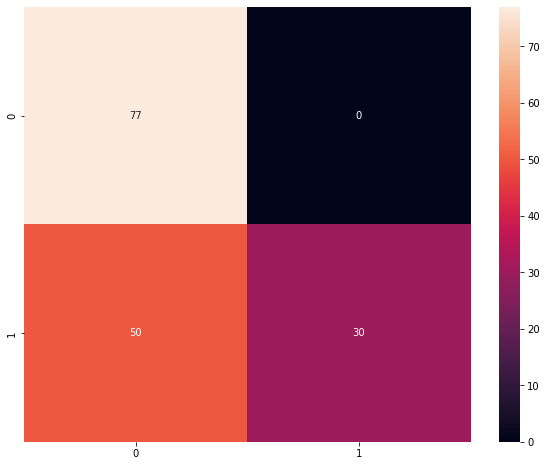

In [188]:
cf_train_matrix = confusion_matrix(y_test_encode, classes)
plt.figure(figsize=(10,8))
sns.heatmap(cf_train_matrix, annot=True, fmt='d')
plt.show()

In [189]:
print(classification_report(y_test_encode, classes))

              precision    recall  f1-score   support

           0       0.61      1.00      0.75        77
           1       1.00      0.38      0.55        80

    accuracy                           0.68       157
   macro avg       0.80      0.69      0.65       157
weighted avg       0.81      0.68      0.65       157



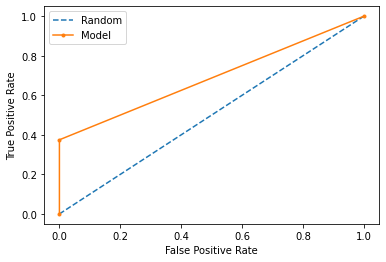

In [190]:
plot_roc_curve(y_test_encode, true_proba, auroc)